# PSD

PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).

author: steeve.laquitaine@epfl.ch

**Execution duration:** : 10 mins for 10 min recordings

**Data description**  
**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * run: 2023_10_18
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)

Power is energy per time: can be compared between traces of different durations (sample length).

### Setup

1. Activate `spikeinterf..` venv

2. precompute data with: $ sbatch cluster/figures/main/marques/psd_10m_buttw_noise_fitd_raw_welch.sbatch

In [83]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import scipy

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

matplotlib.rcParams['agg.path.chunksize'] = 10000


# SETUP PARAMETERS
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency

# SETUP DATASET COMFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_vivo = data_conf_vivo["postprocessing"]["trace_snr"]
POWER_RAW_vivo = data_conf_vivo["analyses"]["traces"]["power"]["raw"]
POWER_PREP_vivo = data_conf_vivo["analyses"]["traces"]["power"]["preprocessed"]

# silico 
data_conf_sili, param_conf_sili = get_config(
    "silico_neuropixels", "concatenated"
).values()
RAW_PATH_sili = data_conf_sili["probe_wiring"]["output"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_sili = data_conf_sili["postprocessing"]["trace_snr"]
POWER_RAW_sili = data_conf_sili["analyses"]["traces"]["power"]["raw"]
POWER_PREP_sili = data_conf_sili["analyses"]["traces"]["power"]["preprocessed"]

# Buccino with fitted gain for layer 5
data_conf_b, _ = get_config("buccino_2020", "2020").values()
RAW_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["raw_gain_ftd"]
PREP_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["prep_gain_ftd"]


# FIGURE SETTINGS
FIG_SIZE = (8.5, 4)
COLOR_VIVO = np.array([153,153,153]) / 255
COLOR_SILI = np.array([228, 26, 28]) / 255
COLOR_BUCCI = np.array([55,126,184]) / 255
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
plt.rcParams['lines.linewidth'] = 1.1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.8 * 1.3
plt.rcParams['ytick.major.width'] = 0.8 * 1.3
plt.rcParams['xtick.major.size'] = 3.5 * 2
plt.rcParams['xtick.minor.size'] = 2 * 2
plt.rcParams['ytick.major.size'] = 3.5 * 2
plt.rcParams['ytick.minor.size'] = 2 * 2

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-06-04 20:42:32,761 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-04 20:42:32,838 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-04 20:42:32,863 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-04 20:42:33,051 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-04 20:42:33,054 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-04 20:42:33,093 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Utils

In [100]:
def load_saved_traces_in_ctx():

    # vivo
    raw_traces_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/1_vivo/marques/campaign/c26_fixed/traces_in_ctx_10m_noise_fitd.npy"
    )
    prep_traces_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/preprocessed/1_vivo/marques/campaign/c26_fixed/traces_in_ctx_10m_noise_fitd.npy"
    )

    # silico
    raw_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/dataeng/recording/traces_in_ctx_10m_noise_fitd.npy"
    )

    prep_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/preprocessed/traces_in_ctx_10m_noise_fitd.npy"
    )
    return raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili


def load_psd_results():

    # save sili
    out_raw_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_raw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_raw_sili = out_raw_sili.item()

    out_prep_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_prep_buttw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_prep_sili = out_prep_sili.item()

    # save vivo
    out_raw_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/full_raw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_raw_vivo = out_raw_vivo.item()

    out_prep_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/full_prep_buttw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_prep_vivo = out_prep_vivo.item()
    return out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo


def get_psd_plot_mean_and_ci(
    out_raw_vivo, out_raw_sili, out_raw_b, out_prep_vivo, out_prep_sili, out_prep_b
):
    # (11s) average over sites
    psd_mean_raw_vivo = np.median(out_raw_vivo["power"], axis=0)
    psd_mean_raw_sili = np.median(out_raw_sili["power"], axis=0)
    psd_mean_raw_b = np.median(out_raw_b["power"], axis=0)
    psd_mean_prep_vivo = np.median(out_prep_vivo["power"], axis=0)
    psd_mean_prep_sili = np.median(out_prep_sili["power"], axis=0)
    psd_mean_prep_b = np.median(out_prep_b["power"], axis=0)

    # confidence intervals
    # vivo
    n_samples = out_raw_vivo["power"].shape[0]
    ci_raw_vivo = 1.96 * np.std(out_raw_vivo["power"], axis=0) / np.sqrt(n_samples)
    ci_prep_vivo = 1.96 * np.std(out_prep_vivo["power"], axis=0) / np.sqrt(n_samples)
    # sili
    n_samples = out_raw_sili["power"].shape[0]
    ci_raw_sili = 1.96 * np.std(out_raw_sili["power"], axis=0) / np.sqrt(n_samples)
    ci_prep_sili = 1.96 * np.std(out_prep_sili["power"], axis=0) / np.sqrt(n_samples)
    # buccino
    n_samples = out_raw_b["power"].shape[0]
    ci_raw_b = 1.96 * np.std(out_raw_b["power"], axis=0) / np.sqrt(n_samples)
    ci_prep_b = 1.96 * np.std(out_prep_b["power"], axis=0) / np.sqrt(n_samples)

    return (
        psd_mean_raw_vivo,
        psd_mean_raw_sili,
        psd_mean_raw_b,
        psd_mean_prep_vivo,
        psd_mean_prep_sili,
        psd_mean_prep_b,
        ci_raw_vivo,
        ci_prep_vivo,
        ci_raw_sili,
        ci_prep_sili,
        ci_raw_b,
        ci_prep_b,
    )


def get_psd_plot_mean_and_ci_for_layer(
    layer: str,
    lyrs_v: list,
    lyrs_s: list,
    out_raw_vivo: dict,
    out_raw_sili: dict,
    out_prep_vivo: dict,
    out_prep_sili: dict,
):

    # get sites in layer
    power_v = out_raw_vivo["power"][lyrs_v == layer, :]
    power_s = out_raw_sili["power"][lyrs_s == layer, :]
    pre_power_v = out_prep_vivo["power"][lyrs_v == layer, :]
    pre_power_s = out_prep_sili["power"][lyrs_s == layer, :]

    # (11s) average over sites
    psd_mean_raw_vivo = np.median(power_v, axis=0)
    psd_mean_raw_sili = np.median(power_s, axis=0)
    psd_mean_prep_vivo = np.median(pre_power_v, axis=0)
    psd_mean_prep_sili = np.median(pre_power_s, axis=0)

    # confidence intervals
    # vivo
    n_samples = power_v.shape[0]
    ci_raw_vivo = 1.96 * np.std(power_v, axis=0) / np.sqrt(n_samples)
    ci_prep_vivo = 1.96 * np.std(pre_power_v, axis=0) / np.sqrt(n_samples)

    # sili
    n_samples = power_s.shape[0]
    ci_raw_sili = 1.96 * np.std(power_s, axis=0) / np.sqrt(n_samples)
    ci_prep_sili = 1.96 * np.std(pre_power_s, axis=0) / np.sqrt(n_samples)

    return (
        psd_mean_raw_vivo,
        psd_mean_raw_sili,
        psd_mean_prep_vivo,
        psd_mean_prep_sili,
        ci_raw_vivo,
        ci_raw_sili,
        ci_prep_vivo,
        ci_prep_sili,
        out_raw_vivo["freq"],
        out_raw_sili["freq"],
        out_prep_vivo["freq"],
        out_prep_sili["freq"],
    )


def get_psd_plot_mean_and_ci_for_layer_5(
    lyrs_v: list,
    lyrs_s: list,
    out_raw_v: dict,
    out_raw_s: dict,
    out_raw_b: dict,
    out_prep_v: dict,
    out_prep_s: dict,
    out_prep_b: dict,
):

    # get sites in layer
    power_v = out_raw_v["power"][lyrs_v == "L5", :]
    power_s = out_raw_s["power"][lyrs_s == "L5", :]
    power_b = out_raw_b["power"]
    pre_power_v = out_prep_v["power"][lyrs_v == "L5", :]
    pre_power_s = out_prep_s["power"][lyrs_s == "L5", :]
    pre_power_b = out_prep_b["power"]

    # (11s) average over sites
    psd_mean_raw_vivo = np.median(power_v, axis=0)
    psd_mean_raw_sili = np.median(power_s, axis=0)
    psd_mean_raw_b = np.median(power_b, axis=0)
    psd_mean_prep_vivo = np.median(pre_power_v, axis=0)
    psd_mean_prep_sili = np.median(pre_power_s, axis=0)
    psd_mean_prep_b = np.median(pre_power_b, axis=0)

    # confidence intervals
    # vivo
    n_samples = power_v.shape[0]
    ci_raw_vivo = 1.96 * np.std(power_v, axis=0) / np.sqrt(n_samples)
    ci_prep_vivo = 1.96 * np.std(pre_power_v, axis=0) / np.sqrt(n_samples)

    # sili
    n_samples = power_s.shape[0]
    ci_raw_sili = 1.96 * np.std(power_s, axis=0) / np.sqrt(n_samples)
    ci_prep_sili = 1.96 * np.std(pre_power_s, axis=0) / np.sqrt(n_samples)

    # buccino
    n_samples = power_b.shape[0]
    ci_raw_b = 1.96 * np.std(power_b, axis=0) / np.sqrt(n_samples)
    ci_prep_b = 1.96 * np.std(pre_power_b, axis=0) / np.sqrt(n_samples)

    return (
        psd_mean_raw_vivo,
        psd_mean_raw_sili,
        psd_mean_raw_b,
        psd_mean_prep_vivo,
        psd_mean_prep_sili,
        psd_mean_prep_b,
        ci_raw_vivo,
        ci_raw_sili,
        ci_raw_b,
        ci_prep_vivo,
        ci_prep_sili,
        ci_prep_b,
        out_raw_v["freq"],
        out_raw_s["freq"],
        out_raw_b["freq"],
        out_prep_v["freq"],
        out_prep_s["freq"],
        out_prep_b["freq"],
    )


def plot_for_layer(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    ci_raw_vivo,
    ci_prep_vivo,
    ci_raw_sili,
    ci_prep_sili,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    YLIM_R = [-0.005, 0.15]
    YLIM_P = [-0.001, 0.05]
    N_MAJOR_TICKS = 4
    SIZE = 3
    ALPHA = 0.7
    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # Raw panel --------------------------------

    # VIVO
    axes[0].plot(
        freq_raw_v,
        psd_mean_raw_vivo,
        linestyle="none",
        marker="o",
        markersize=SIZE,
        color=COLOR_VIVO,
        label="vivo",
        rasterized=True,  # cheaper
    )
    axes[0].plot(
        freq_raw_s,
        psd_mean_raw_sili,
        linestyle="none",
        marker="o",
        markersize=SIZE,
        color=COLOR_SILI,
        label="sili",
        rasterized=True,  # cheaper
    )

    # confidence interval
    axes[0].fill_between(
        freq_raw_v,
        (psd_mean_raw_vivo - ci_raw_vivo),
        (psd_mean_raw_vivo + ci_raw_vivo),
        color=COLOR_VIVO,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[0].fill_between(
        freq_raw_s,
        (psd_mean_raw_sili - ci_raw_sili),
        (psd_mean_raw_sili + ci_raw_sili),
        color=COLOR_SILI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([-1, SFREQ_SILICO / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect axes (R style)
    axes[0].spines["bottom"].set_position(("axes", -0.05))
    axes[0].yaxis.set_ticks_position("left")
    axes[0].spines["left"].set_position(("axes", -0.05))
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([0, SFREQ_SILICO / 2])

    # Preprocessed panel --------------------------------

    # VIVO
    axes[1].plot(
        freq_prep_v,
        psd_mean_prep_vivo,
        linestyle="none",
        marker="o",
        markersize=SIZE,
        color=COLOR_VIVO,
        label="vivo",
        rasterized=True,  # cheaper
    )
    axes[1].plot(
        freq_prep_s,
        psd_mean_prep_sili,
        color=COLOR_SILI,
        label="silico",
        marker="o",
        markersize=SIZE,
        rasterized=True,  # cheaper
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlabel("")
    axes[1].set_xscale("log")
    axes[1].spines[["right", "top"]].set_visible(False)
    # axes[1].set_yticklabels([])
    # axes[1].set_yticks([])
    # axes[1].set_xticks([])
    axes[1].set_ylim(YLIM_P)

    axes[1].set_xlim([-1, SFREQ_SILICO / 2])
    axes[1].tick_params(axis="x", which="minor", colors="black")
    axes[1].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[1].tick_params(which="both")
    axes[1].xaxis.set_major_locator(locmaj)
    axes[1].xaxis.set_minor_locator(locmin)
    axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect axes (R style)
    axes[1].spines["bottom"].set_position(("axes", -0.05))
    axes[1].yaxis.set_ticks_position("left")
    axes[1].spines["left"].set_position(("axes", -0.05))
    axes[1].set_ylim(YLIM_P)
    axes[1].set_xlim([0, SFREQ_SILICO / 2])

    fig.tight_layout(**tight_layout_cfg)
    return axes


def plot_for_layer_5(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_raw_sili,
    ci_raw_b,
    ci_prep_vivo,
    ci_prep_sili,
    ci_prep_b,
    freq_raw_v,
    freq_raw_s,
    freq_raw_b,
    freq_prep_v,
    freq_prep_s,
    freq_prep_b,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    YLIM_R = [-0.005, 0.12]
    YLIM_P = [-0.001, 0.05]
    N_MAJOR_TICKS = 4
    SIZE = 3
    ALPHA = 0.7
    pm = {
        "linestyle": "none",
        "marker": "o",
        "markersize": SIZE,
        "rasterized": True,
    }
    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # Raw
    axes[0].plot(freq_raw_v, psd_mean_raw_vivo, color=COLOR_VIVO, label="vivo", **pm)
    axes[0].plot(freq_raw_s, psd_mean_raw_sili, color=COLOR_SILI, label="sili", **pm)
    axes[0].plot(freq_raw_b, psd_mean_raw_b, color=COLOR_BUCCI, label="buccino", **pm)

    # confidence interval
    axes[0].fill_between(
        freq_raw_v,
        (psd_mean_raw_vivo - ci_raw_vivo),
        (psd_mean_raw_vivo + ci_raw_vivo),
        color=COLOR_VIVO,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[0].fill_between(
        freq_raw_s,
        (psd_mean_raw_sili - ci_raw_sili),
        (psd_mean_raw_sili + ci_raw_sili),
        color=COLOR_SILI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[0].fill_between(
        freq_raw_b,
        (psd_mean_raw_b - ci_raw_b),
        (psd_mean_raw_b + ci_raw_b),
        color=COLOR_BUCCI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([-1, SFREQ_SILICO / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect axes (R style)
    axes[0].spines["bottom"].set_position(("axes", -0.05))
    axes[0].yaxis.set_ticks_position("left")
    axes[0].spines["left"].set_position(("axes", -0.05))
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([0, SFREQ_SILICO / 2])

    axes[1].plot(
        freq_prep_v,
        psd_mean_prep_vivo,
        linestyle="none",
        marker="o",
        markersize=SIZE,
        color=COLOR_VIVO,
        label="vivo",
        rasterized=True,  # cheaper
    )
    axes[1].plot(
        freq_prep_s,
        psd_mean_prep_sili,
        color=COLOR_SILI,
        label="silico",
        marker="o",
        markersize=SIZE,
        rasterized=True,  # cheaper
    )
    axes[1].plot(
        freq_prep_b,
        psd_mean_prep_b,
        color=COLOR_BUCCI,
        label="Buccino",
        marker="o",
        markersize=SIZE,
        rasterized=True,  # cheaper
    )

    # confidence interval
    axes[1].fill_between(
        freq_prep_v,
        (psd_mean_prep_vivo - ci_prep_vivo),
        (psd_mean_prep_vivo + ci_prep_vivo),
        color=COLOR_VIVO,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[1].fill_between(
        freq_prep_s,
        (psd_mean_prep_sili - ci_prep_sili),
        (psd_mean_prep_sili + ci_prep_sili),
        color=COLOR_SILI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )
    axes[1].fill_between(
        freq_prep_b,
        (psd_mean_prep_b - ci_prep_b),
        (psd_mean_prep_b + ci_prep_b),
        color=COLOR_BUCCI,
        linewidth=0,
        alpha=ALPHA,
        rasterized=True,
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlabel("")
    axes[1].set_xscale("log")
    axes[1].spines[["right", "top"]].set_visible(False)
    # axes[1].set_yticklabels([])
    # axes[1].set_yticks([])
    # axes[1].set_xticks([])
    axes[1].set_ylim(YLIM_P)

    axes[1].set_xlim([-1, SFREQ_SILICO / 2])
    axes[1].tick_params(axis="x", which="minor", colors="black")
    axes[1].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[1].tick_params(which="both")
    axes[1].xaxis.set_major_locator(locmaj)
    axes[1].xaxis.set_minor_locator(locmin)
    axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # disconnect axes (R style)
    axes[1].spines["bottom"].set_position(("axes", -0.05))
    axes[1].yaxis.set_ticks_position("left")
    axes[1].spines["left"].set_position(("axes", -0.05))
    axes[1].set_ylim(YLIM_P)
    axes[1].set_xlim([0, SFREQ_SILICO / 2])

    fig.tight_layout(**tight_layout_cfg)

    return axes

### (1s)Load dataset

In [4]:
# Load traces
# load raw traces
RawVivo = si.load_extractor(RAW_PATH_vivo)
RawSili = si.load_extractor(RAW_PATH_sili)

# load preprocessed traces
PreprocessedVivo = si.load_extractor(PREP_PATH_vivo)
PreprocessedSili = si.load_extractor(PREP_PATH_sili)

# select first 10 minutes
RawVivo = RawVivo.frame_slice(start_frame=0, end_frame=SFREQ_VIVO * 10 * 60)
PreprocessedVivo = PreprocessedVivo.frame_slice(
    start_frame=0, end_frame=SFREQ_VIVO * 10 * 60
)
RawSili = RawSili.frame_slice(start_frame=0, end_frame=SFREQ_SILICO * 10 * 60)
PreprocessedSili = PreprocessedSili.frame_slice(
    start_frame=0, end_frame=SFREQ_SILICO * 10 * 60
)

# sanity check
assert RawSili.get_total_duration() == 10 * 60, "not 10 min"
assert RawVivo.get_total_duration() == 10 * 60, "not 10 min"

### Validate amplitude

#### (1s)Keep cortical sites

In [5]:
# Keep traces from good sites (in cortex)

# silico
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_sili = RawSili.get_property("layers")
site_layers_sili = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_sili
]
IN_CTX = np.isin(site_layers_sili, layers)
sites_sili = np.where(IN_CTX)[0]

# vivo
site_layers_vivo = RawVivo.get_property("layers")
IN_CTX = np.isin(site_layers_vivo, layers)
sites_vivo = np.where(IN_CTX)[0]

# keep only the layers
site_layers_sili = np.array(site_layers_sili)[sites_sili]
site_layers_vivo = np.array(site_layers_vivo)[sites_vivo]

#### (20s)Load traces and PSD in ctx

In [6]:
# load traces and PSD Marques
raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili = (
    load_saved_traces_in_ctx()
)
out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo = load_psd_results()

# load PSD Buccino (l5)
out_raw_b = np.load(RAW_PATH_GAIN_FTD_B, allow_pickle=True).item()
out_prep_b = np.load(PREP_PATH_GAIN_FTD_B, allow_pickle=True).item()

# unit-test
assert out_raw_vivo["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert out_raw_sili["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert out_raw_b["freq"][1] == 1.0, "psd resolution should be 1Hz"

#### (2m) Plot column

The PSD is averaged over sites by layer. We used the median of the mean due to the small number of sites per layer.

#### Mann Whitney stats

* null hypothesis: the biophysical model and in vivo power spectra are the same, below 100 Hz.
* method: we used Mann Whitney to compare in vivo and simulated psd in rolling windows of size 5.

In [7]:
# compare biophysical model with in vivo PSD
# # find indices of 100 Hz
ix_100_hz_vivo = np.where(out_raw_vivo["freq"] == 100)[0][0]
ix_100_hz_sili = np.where(out_raw_vivo["freq"] == 100)[0][0]


def rolling_mw_test(sample_x, sample_y, window_size: int = 5):
    results = []
    pvalues = []
    for i in range(sample_x.shape[1] - window_size + 1):
        result = scipy.stats.mannwhitneyu(
            sample_x[:, i : i + window_size].flatten(),
            sample_y[:, i : i + window_size].flatten(),
        )
        # store results
        results.append(result)
        pvalues.append(result.pvalue)
    return (np.array(pvalues), results)


window_size = 5

# stats raw
pvalues_raw, results_raw = rolling_mw_test(
    out_raw_vivo["power"], out_raw_sili["power"], 5
)

# stats preprocessed
pvalues_prep, results_prep = rolling_mw_test(
    out_prep_vivo["power"], out_prep_sili["power"], 5
)

# statistically significantly different (=1)
pvalues005_raw = (pvalues_raw < 0.05).astype(float)
pvalues005_prep = (pvalues_prep < 0.05).astype(float)

print("ratio of significant windows (raw):", sum(pvalues005_raw) / len(pvalues005_raw))
print(
    "ratio of significant windows (prep):", sum(pvalues005_prep) / len(pvalues005_prep)
)
print("max pvalue below 0.05 (raw):", max(pvalues_raw[pvalues_raw < 0.05]))
print("max pvalue below 0.05 (prep):", max(pvalues_prep[pvalues_prep < 0.05]))

ratio of significant windows (raw): 0.9989331199573248
ratio of significant windows (prep): 1.0
max pvalue below 0.05 (raw): 0.033062739047017065
max pvalue below 0.05 (prep): 0.0006804144775757188


### Plot

compute plot

In [10]:
# calculate psd plot stats
(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_prep_vivo,
    ci_raw_sili,
    ci_prep_sili,
    ci_raw_b,
    ci_prep_b,
) = get_psd_plot_mean_and_ci(
    out_raw_vivo, out_raw_sili, out_raw_b, out_prep_vivo, out_prep_sili, out_prep_b
)

plot avg

In [103]:
import os
import matplotlib.pyplot as plt

# import seaborn
import numpy as np

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_R = [0, 0.15]
YLIM_P = [0, 0.05]
N_MAJOR_TICKS = 4
SIZE = 3
ALPHA = 0.7
fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE, dpi=300)

# Raw panel (8 secs) --------------------------------

# VIVO
pm = {
    "linestyle": "none",
    "marker": "o",
    "markersize": SIZE,
    "rasterized": True,
}

# 3 secs
axes[0].plot(
    out_raw_vivo["freq"], psd_mean_raw_vivo, label="vivo", color=COLOR_VIVO, **pm
)
axes[0].plot(
    out_raw_sili["freq"], psd_mean_raw_sili, color=COLOR_SILI, label="silico", **pm
)

# confidence interval
axes[0].fill_between(
    out_raw_vivo["freq"],
    (psd_mean_raw_vivo - ci_raw_vivo),
    (psd_mean_raw_vivo + ci_raw_vivo),
    color=COLOR_VIVO,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[0].fill_between(
    out_raw_sili["freq"],
    (psd_mean_raw_sili - ci_raw_sili),
    (psd_mean_raw_sili + ci_raw_sili),
    color=COLOR_SILI,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# STATS: mark pvalues < 0.05
x = out_raw_vivo["freq"][np.where(pvalues005_raw == 1)[0]]
y = pvalues005_raw[np.where(pvalues005_raw == 1)[0]] * YLIM_R[1]
axes[0].plot(x, y, "k.", markersize=1, rasterized=True)

# 100 Hz (LFP)
axes[0].vlines(
    x=100, ymin=YLIM_R[0], ymax=YLIM_R[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[0].set_xscale("log")

# axes[0].set_xlabel("frequency [Hz]")
# axes[0].set_ylabel("Power ($\mu V^2$/Hz)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# disconnect axes (R style)
axes[0].spines["bottom"].set_position(("axes", -0.05))
axes[0].yaxis.set_ticks_position("left")
axes[0].spines["left"].set_position(("axes", -0.05))
axes[0].set_ylim(YLIM_R)
axes[0].set_xlim([0, SFREQ_SILICO / 2])


# Preprocessed panel ************************************************************


axes[1].plot(
    out_prep_vivo["freq"],
    psd_mean_prep_vivo,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_VIVO,
    label="vivo",
    rasterized=True,
)
axes[1].plot(
    out_prep_sili["freq"],
    psd_mean_prep_sili,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_SILI,
    label="silico",
    rasterized=True,
)

# confidence interval
axes[1].fill_between(
    out_prep_vivo["freq"],
    (psd_mean_prep_vivo - ci_prep_vivo),
    (psd_mean_prep_vivo + ci_prep_vivo),
    color=COLOR_VIVO,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[1].fill_between(
    out_prep_sili["freq"],
    (psd_mean_prep_sili - ci_prep_sili),
    (psd_mean_prep_sili + ci_prep_sili),
    color=COLOR_SILI,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# mark pvalues < 0.05
x = out_prep_vivo["freq"][np.where(pvalues005_prep == 1)[0]]
y = pvalues005_prep[np.where(pvalues005_prep == 1)[0]] * YLIM_P[1]
axes[1].plot(x, y, "k.", markersize=1, rasterized=True)

# 100 Hz (LFP)
axes[1].vlines(
    x=100, ymin=YLIM_P[0], ymax=YLIM_P[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[1].tick_params(which="both")
axes[1].xaxis.set_major_locator(locmaj)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# disconnect x,y axes
axes[1].spines["bottom"].set_position(("axes", -0.05))
axes[1].yaxis.set_ticks_position("left")
axes[1].spines["left"].set_position(("axes", -0.05))
axes[1].set_ylim(YLIM_P)
axes[1].set_xlim([0, SFREQ_SILICO / 2])
axes[1].set_yticks([0, 0.05], [0, 0.05])

# tight
fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[1].get_legend().remove()

# save (12MB figure)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_10m_psd_column_raw_welch_and_stats.svg",
    **savefig_cfg
)

#### plot layer 1

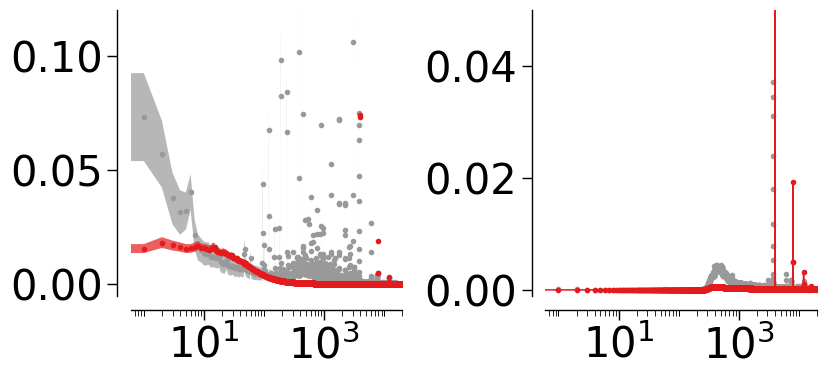

In [89]:
# compute data
(
    psd_mean_raw_vivo_L1,
    psd_mean_raw_sili_L1,
    psd_mean_prep_vivo_L1,
    psd_mean_prep_sili_L1,
    ci_raw_vivo_L1,
    ci_raw_sili_L1,
    ci_prep_vivo_L1,
    ci_prep_sili_L1,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    "L1",
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L1,
    psd_mean_raw_sili_L1,
    psd_mean_prep_vivo_L1,
    psd_mean_prep_sili_L1,
    ci_raw_vivo_L1,
    ci_prep_vivo_L1,
    ci_raw_sili_L1,
    ci_prep_sili_L1,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
)

# save
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer1_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 2/3

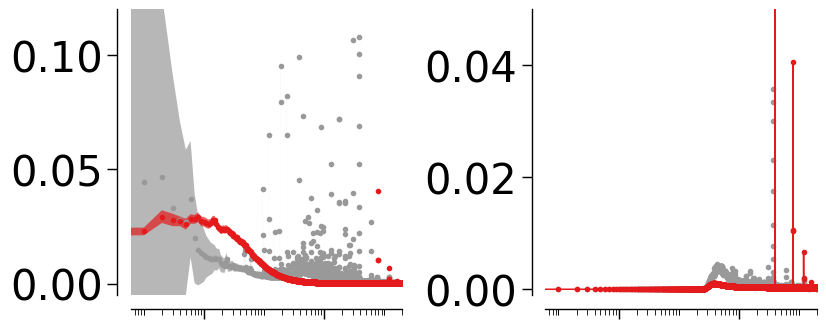

In [90]:
# compute data
(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_vivo_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    "L2_3",
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_prep_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# save
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer2_3_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 4

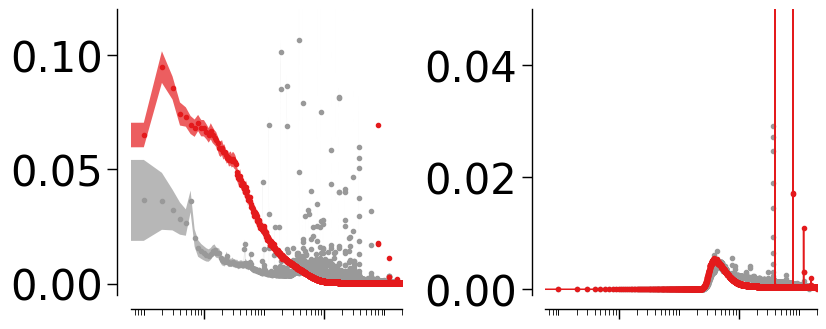

In [91]:
# compute data
(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_vivo_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    "L4",
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_prep_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# save
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer4_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 5

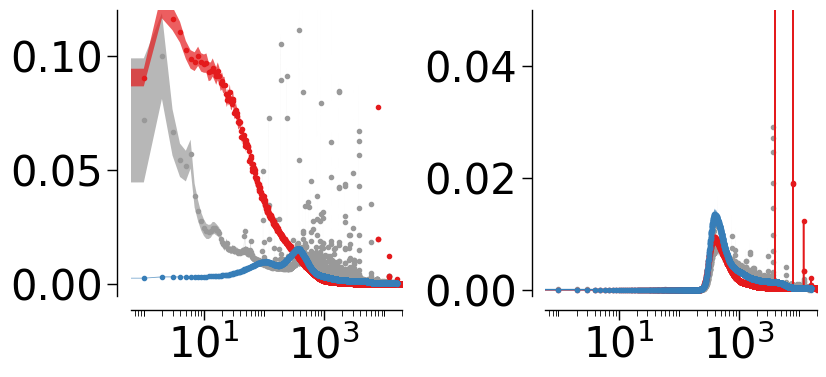

In [98]:
(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_raw_sili,
    ci_raw_b,
    ci_prep_vivo,
    ci_prep_sili,
    ci_prep_b,
    freq_raw_v,
    freq_raw_s,
    freq_raw_b,
    freq_prep_v,
    freq_prep_s,
    freq_prep_b,
) = get_psd_plot_mean_and_ci_for_layer_5(
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_raw_b,
    out_prep_vivo,
    out_prep_sili,
    out_prep_b,
)

# plot
plot_for_layer_5(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_raw_sili,
    ci_raw_b,
    ci_prep_vivo,
    ci_prep_sili,
    ci_prep_b,
    freq_raw_v,
    freq_raw_s,
    freq_raw_b,
    freq_prep_v,
    freq_prep_s,
    freq_prep_b,
)

plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer5_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 6

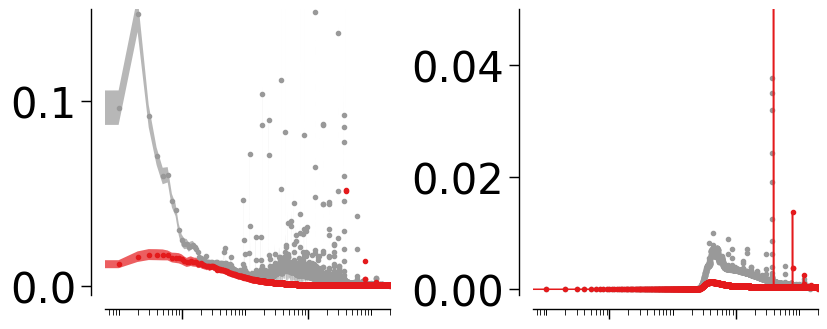

In [101]:
# compute data
(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_vivo_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    "L6",
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_prep_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# save
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer6_column_raw_welch.svg",
    **savefig_cfg
)

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
